# GHG
This notebook will be used to measure indicators for EDGI/EEW's "Climate Data Project" report. It will pull greenhouse gas emissions reported under EPA's Greenhouse Gas Reporting Program (GHGRP).

GHGRP only covers certain facilities - those who directly emit GHGs and those (e.g. oil refineries) who supply products (e.g. gasoline) that result in GHGs. GHGs from land use change is not included. Still, because it includes both direct emitters (e.g. coal-fired power plants) and suppliers (e.g. of the gas you burn in your car), the GHGRP is estimated to account for 85-90% of all US GHGs. Source: https://www.epa.gov/ghgreporting/ghgrp-and-us-inventory-greenhouse-gas-emissions-and-sinks

In [7]:
%pip install requests
%pip install pandas
%pip install openpyxl
%pip install matplotlib
%pip install seaborn
%pip install plotly-express
%pip install plotly-geo
%pip install geopandas
%pip install pyshp
%pip install shapely
%pip install pyxlsb
%pip install pywaffle

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/25.6 MB ? eta -:--:--
   ------ --------------------------------- 4.2/25.6 MB 27.6 MB/s eta 0:00:01
   --------------- ------------------------ 10.2/25.6 MB 27.2 MB/s eta 0:00:01
   ------------------------ --------------- 16.

In [1]:
# Base imports and data structs used throughout the code
# Always run this cell first

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import requests, zipfile, io
from pywaffle import Waffle
import os
import numpy as np
import plotly.express
from urllib.request import urlopen
import json
import re
import shutil
from pyxlsb import open_workbook
from ipywidgets import interact, IntSlider

direct_emissions_field_names = {
    "Direct Point Emitters": "Total reported direct emissions",
    "Onshore Oil & Gas Prod.": "Total reported emissions from Onshore Oil & Gas Production ",
    "Gathering & Boosting": "Total reported emissions from Gathering & Boosting",
    "Transmission Pipelines": "Total reported direct emissions from Transmission Pipelines",
    "LDC - Direct Emissions": "Total reported direct emissions from Local Distribution Companies",
    "SF6 from Elec. Equip.": "Total reported direct emissions from Electrical Equipment Use"
}

# Define supplier-related columns
supplier_columns = [
    "GHG Quantity Associated with Coal-based liquid fuel production",
    "GHG Quantity Associated with Petroleum Products Produced",
    "GHG Quantity Associated with Petroleum Products Imported",
    "GHG Quantity Associated with Petroleum Products Exported",
    "GHG Quantity Associated with Natural Gas Supply",
    "GHG Quantity Associated with Natural Gas Liquids Supply",
    "GHG Quantity Associated with CO2 Supply "
]

# Short names for supplier columns, looks nice in graphs when displaying legends
supplier_columns_short = [
    "Coal-based liquid fuel production",
    "Petroleum Products Produced",
    "Petroleum Products Imported",
    "Petroleum Products Exported",
    "Natural Gas Supply",
    "Natural Gas Liquids Supply",
    "CO2 Supply "
]

direct_columns = [
    "Direct Point Emitters",
    "Onshore Oil & Gas Prod.",
    "Gathering & Boosting",
    "Transmission Pipelines",
    "LDC - Direct Emissions",
    "SF6 from Elec. Equip."
]

# Standard directory paths to retrieve/save data
DATA_DIR = "ghgrp_raw_data"
OUTPUT_DATA_DIR = "output_files"

In [3]:
# GHGRP
# Access: https://www.epa.gov/system/files/other-files/2024-10/2023_data_summary_spreadsheets.zip
# Data dictionary: https://www.epa.gov/rsei/rsei-data-dictionary-elements-data
# Pull the zip file into this notebook
url = "https://www.epa.gov/system/files/other-files/2024-10/2023_data_summary_spreadsheets.zip"
r = requests.get(url, verify=False)
# Unzip the file
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("ghgrp_raw_data")

c:\Users\Ashok\Documents\GitHub\GHG-CDP\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.epa.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [5]:
# This block will use 'ghgrp_raw_data\ghgp_data_parent_company.xlsb' to create a parent company lookup for each facility-year combination.
# We will use this in the next code block where the "master data set" of all facility data is stored.
parent_records = []

parent_path = os.path.join(DATA_DIR, "ghgp_data_parent_company.xlsb")

with open_workbook(parent_path) as wb:
    for sheet in wb.sheets:
        year = int(sheet)
        with wb.get_sheet(sheet) as sh:
            rows = list(sh.rows())
            header = [c.v for c in rows[0]]

            for r in rows[1:]:
                rec = dict(zip(header, [c.v for c in r]))
                rec["Year"] = year
                parent_records.append(rec)

parent_df = pd.DataFrame(parent_records)

parent_df = parent_df[[
    "GHGRP FACILITY ID",
    "Year",
    "PARENT COMPANY NAME",
    "PARENT CO. PERCENT OWNERSHIP"
]]

parent_df.rename(columns={
    "GHGRP FACILITY ID": "Facility Id",
    "PARENT COMPANY NAME": "Parent Company",
    "PARENT CO. PERCENT OWNERSHIP": "Parent Ownership %"
}, inplace=True)

# This line first sorts by parent ownership percentage, THEN removes duplicates, ensuring that the listed parent company is only the one with majority ownership.
# Perhaps we could change this to somehow reflect percentage ownership properly, i.e. giving partial points to companies based on the amount they own?
parent_df = (
    parent_df
    .sort_values("Parent Ownership %", ascending=False)
    .drop_duplicates(["Facility Id", "Year"])
)

print(parent_df.head())

        Facility Id  Year                      Parent Company  \
134256    1012137.0  2010                       SAEZ HOLDINGS   
0         1000001.0  2023                  PUGET HOLDINGS LLC   
134240    1011672.0  2010  Grand Haven Board fo Light & Power   
134239    1011640.0  2010             LACTALIS AMERICAN GROUP   
134238    1011466.0  2010  MINNESOTA POLLUTION CONTROL AGENCY   

        Parent Ownership %  
134256               100.0  
0                    100.0  
134240               100.0  
134239               100.0  
134238               100.0  


In [6]:
years = range(2010, 2024)
all_data = []

for year in years:
    filepath = os.path.join(DATA_DIR, f"ghgp_data_{year}.xlsx")
    print(f"Processing {filepath}...")

    year_dfs = []

    # Direct Emitters:
    for clean_name, col_header in direct_emissions_field_names.items():
        retrieve_from_sheet_name = clean_name
        if year < 2018 and retrieve_from_sheet_name == "Direct Point Emitters":
            retrieve_from_sheet_name = "Direct Emitters"

        try:
            df = pd.read_excel(filepath, sheet_name=retrieve_from_sheet_name, header=3)
        except Exception as e:
            print(f"  Skipping sheet {retrieve_from_sheet_name}: {e}")
            continue

        keep_cols = [c for c in ["Facility Id", "Facility Name", col_header] if c in df.columns]
        if len(keep_cols) < 3:
            continue

        df = df[keep_cols].copy()
        df.rename(columns={col_header: clean_name}, inplace=True)
        df["Year"] = year
        df = df.groupby(["Facility Id", "Facility Name", "Year"], as_index=False).sum(numeric_only=True)
        year_dfs.append(df)

    # Suppliers:
    try:
        df_sup = pd.read_excel(filepath, sheet_name="Suppliers", header=3)
        df_sup.replace("confidential", pd.NA, inplace=True)
        
        # Ensure all expected columns exist — add any that are missing as 0.0
        for col in supplier_columns:
            if col not in df_sup.columns:
                df_sup[col] = 0.0
            else:
                df_sup[col] = pd.to_numeric(df_sup[col], errors="coerce")

        # Now select columns (guaranteed to exist)
        keep_cols = ["Facility Id", "Facility Name"] + supplier_columns

        df_sup = df_sup[keep_cols].copy()
        df_sup["Year"] = year
        #print(df_sup.head())

        # Aggregate to facility-year level
        df_sup = df_sup.groupby(["Facility Id", "Facility Name", "Year"], as_index=False).sum(numeric_only=True)
        #print(df_sup.head())

        year_dfs.append(df_sup)

        missing = [col for col in supplier_columns if col not in df_sup.columns]
        if missing:
            print(f"  {year}: Missing supplier columns: {missing}")

    except Exception as e:
        print(f"  Skipping Suppliers sheet: {e}")
    
    # list of metadata columns that should appear only once per facility-year
    meta_cols = ["FRS Id", "City", "State", "Zip Code", "Address", "County", "Latitude", "Longitude"]

    # Merge all sheets for the year into one (keep first df fully, drop metadata from later dfs)
    if year_dfs:
        merged_year = year_dfs[0].copy()
        for df_other in year_dfs[1:]:
            df_other = df_other.copy()
            # remove metadata cols from df_other if they already exist in merged_year (avoid duplicate columns)
            cols_to_drop = [c for c in meta_cols if c in df_other.columns and c in merged_year.columns]
            if cols_to_drop:
                df_other = df_other.drop(columns=cols_to_drop)

            merged_year = pd.merge(
                merged_year,
                df_other,
                on=["Facility Id", "Facility Name", "Year"],
                how="outer"
            )
        all_data.append(merged_year)

# Final processing, aligning columns, etc.
aggregated_all_years = pd.concat(all_data, ignore_index=True)

# Ensure every possible column (across all years) exists, filling with NaN if absent
all_columns = sorted(set().union(*(df.columns for df in all_data)))
aggregated_all_years = aggregated_all_years.reindex(columns=all_columns)

# Merge with parent company data:
aggregated_all_years = aggregated_all_years.merge(
    parent_df,
    on=["Facility Id", "Year"],
    how="left"
)

aggregated_all_years["Total Direct Emissions"] = aggregated_all_years[direct_columns].sum(axis=1, skipna=True)
aggregated_all_years["Total Supplier Emissions"] = aggregated_all_years[supplier_columns].sum(axis=1, skipna=True)
aggregated_all_years["Total Emissions"] = (aggregated_all_years["Total Direct Emissions"] + aggregated_all_years["Total Supplier Emissions"])

print("\n=== Aggregated Emissions (Sample) ===")
print(aggregated_all_years.head())
if not os.path.exists(OUTPUT_DATA_DIR):
    os.mkdir(OUTPUT_DATA_DIR)
filepath = os.path.join(OUTPUT_DATA_DIR, f"aggregated_emissions_by_facility.csv")
aggregated_all_years.to_csv(filepath, index=False)


Processing ghgrp_raw_data\ghgp_data_2010.xlsx...
  Skipping sheet Onshore Oil & Gas Prod.: Worksheet named 'Onshore Oil & Gas Prod.' not found
  Skipping sheet Gathering & Boosting: Worksheet named 'Gathering & Boosting' not found
  Skipping sheet Transmission Pipelines: Worksheet named 'Transmission Pipelines' not found
  Skipping sheet LDC - Direct Emissions: Worksheet named 'LDC - Direct Emissions' not found
  Skipping sheet SF6 from Elec. Equip.: Worksheet named 'SF6 from Elec. Equip.' not found
Processing ghgrp_raw_data\ghgp_data_2011.xlsx...
  Skipping sheet Gathering & Boosting: Worksheet named 'Gathering & Boosting' not found
  Skipping sheet Transmission Pipelines: Worksheet named 'Transmission Pipelines' not found
Processing ghgrp_raw_data\ghgp_data_2012.xlsx...
  Skipping sheet Gathering & Boosting: Worksheet named 'Gathering & Boosting' not found
  Skipping sheet Transmission Pipelines: Worksheet named 'Transmission Pipelines' not found
Processing ghgrp_raw_data\ghgp_data_2

In [4]:
# Load your saved data (if you already wrote it to CSV)
filepath = os.path.join(OUTPUT_DATA_DIR, "aggregated_emissions_by_facility.csv")
aggregated_all_years = pd.read_csv(filepath)

# Compute total direct emissions per year
total_per_year = (
    aggregated_all_years
    .groupby("Year")[direct_columns + ["Total Direct Emissions"]]
    .sum(min_count=1)  # ignore all-NaN rows
    .reset_index()
)

# # Create a new column for total of *all* direct emissions combined
# total_per_year["Total Direct Emissions"] = total_per_year[direct_columns].sum(axis=1, skipna=True)

total_per_year.head()

filepath = os.path.join(OUTPUT_DATA_DIR, "aggregated_direct_emissions_by_year.csv")
total_per_year.to_csv(filepath, index=False)
print("\nSaved to aggregated_direct_emissions_by_year.csv")


Saved to aggregated_direct_emissions_by_year.csv


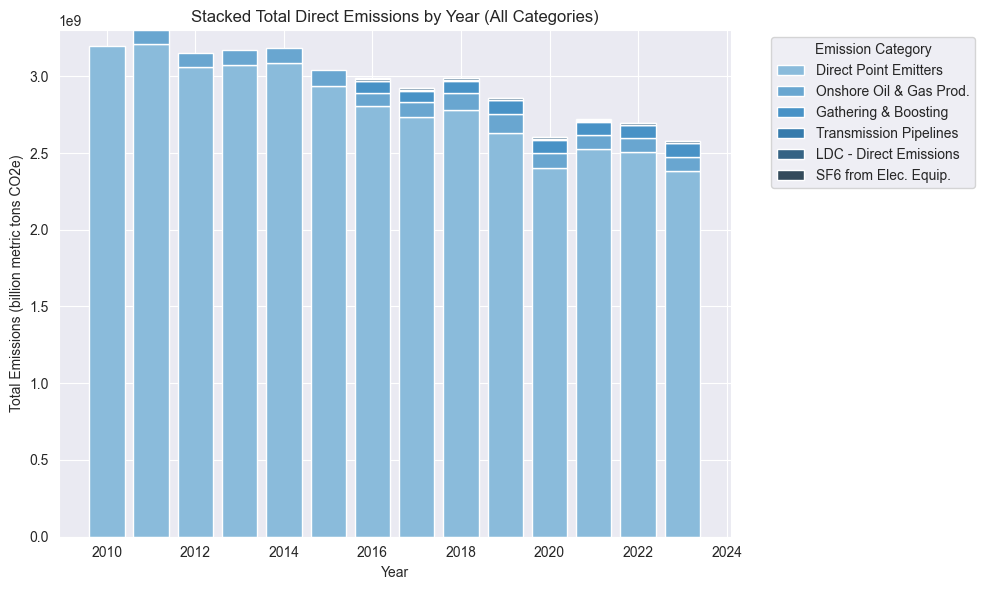

In [18]:
sns.set_style("darkgrid")

plt.figure(figsize=(10, 6))

filepath = os.path.join(OUTPUT_DATA_DIR, "aggregated_direct_emissions_by_year.csv")
total_per_year = pd.read_csv(filepath)

bottom_vals = None
colors = sns.color_palette("Blues_d", n_colors=len(direct_columns))

for i, col in enumerate(direct_columns):
    plt.bar(
        total_per_year["Year"],
        total_per_year[col],
        bottom=bottom_vals,
        color=colors[i],
        label=col
    )
    bottom_vals = (
        total_per_year[col]
        if bottom_vals is None
        else bottom_vals + total_per_year[col]
    )

plt.title("Stacked Total Direct Emissions by Year (All Categories)")
plt.xlabel("Year")
plt.ylabel("Total Emissions (billion metric tons CO2e)")
plt.legend(title="Emission Category", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


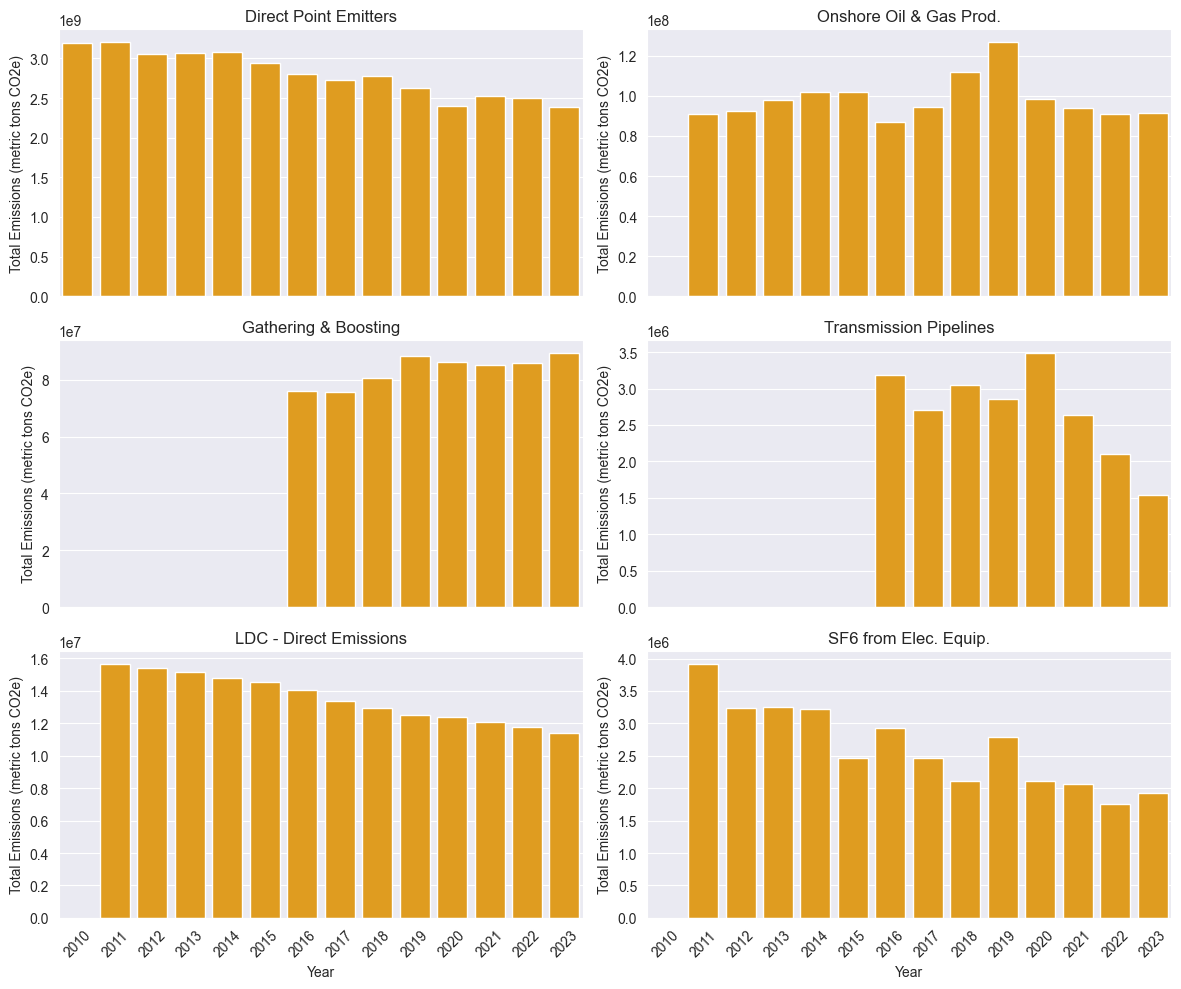

In [12]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10), sharex=True)
axes = axes.flatten()

for i, col in enumerate(direct_columns):
    sns.barplot(
        data=total_per_year,
        x="Year",
        y=col,
        color="Orange",
        ax=axes[i]
    )
    axes[i].set_title(col)
    axes[i].set_ylabel("Total Emissions (metric tons CO2e)")
    axes[i].set_xlabel("Year")
    axes[i].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


In [6]:
# Similar code as above, but now for suppliers.
# Load your saved data (if you already wrote it to CSV)
filepath = os.path.join(OUTPUT_DATA_DIR, "aggregated_emissions_by_facility.csv")
aggregated_all_years = pd.read_csv(filepath)
print(aggregated_all_years.head())
# Compute total direct emissions per year
total_per_year_suppliers = (
    aggregated_all_years
    .groupby("Year")[supplier_columns + ["Total Supplier Emissions"]]
    .sum(min_count=1)  # ignore all-NaN rows
    .reset_index()
)

# Create a new column for total of *all* supplier emissions combined
# total_per_year_suppliers["Supplier Emissions"] = total_per_year_suppliers[supplier_columns].sum(axis=1, skipna=True)

total_per_year_suppliers.head()

filepath = os.path.join(OUTPUT_DATA_DIR, "aggregated_supplier_emissions_by_year.csv")
total_per_year_suppliers.to_csv(filepath, index=False)
print("\nSaved to aggregated_supplier_emissions_by_year.csv")

   Direct Point Emitters  Facility Id                    Facility Name  \
0             293290.944      1000001  PSE Ferndale Generating Station   
1             108094.104      1000002                Ardagh Glass Inc.   
2              78408.200      1000003                Ardagh Glass Inc.   
3              62346.096      1000004                Ardagh Glass Inc.   
4              74196.872      1000005                Ardagh Glass Inc.   

   GHG Quantity Associated with CO2 Supply   \
0                                       NaN   
1                                       NaN   
2                                       NaN   
3                                       NaN   
4                                       NaN   

   GHG Quantity Associated with Coal-based liquid fuel production  \
0                                                NaN                
1                                                NaN                
2                                                NaN             

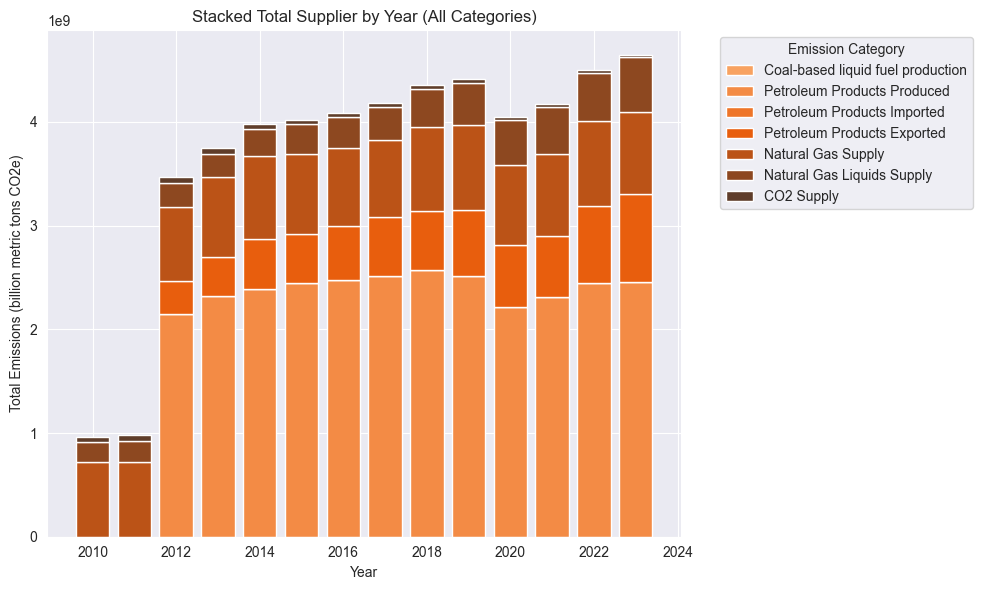

In [17]:
plt.figure(figsize=(10, 6))
sns.set_style("darkgrid")

filepath = os.path.join(OUTPUT_DATA_DIR, "aggregated_supplier_emissions_by_year.csv")
total_per_year_suppliers = pd.read_csv(filepath)

bottom_vals = None
colors = sns.color_palette("Oranges_d", n_colors=len(supplier_columns))

for i, col in enumerate(supplier_columns):
    plt.bar(
        total_per_year_suppliers["Year"],
        total_per_year_suppliers[col],
        bottom=bottom_vals,
        color=colors[i],
        label=supplier_columns_short[i]
    )
    bottom_vals = (
        total_per_year_suppliers[col]
        if bottom_vals is None
        else bottom_vals + total_per_year_suppliers[col]
    )

plt.title("Stacked Total Supplier by Year (All Categories)")
plt.xlabel("Year")
plt.ylabel("Total Emissions (billion metric tons CO2e)")
plt.legend(title="Emission Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


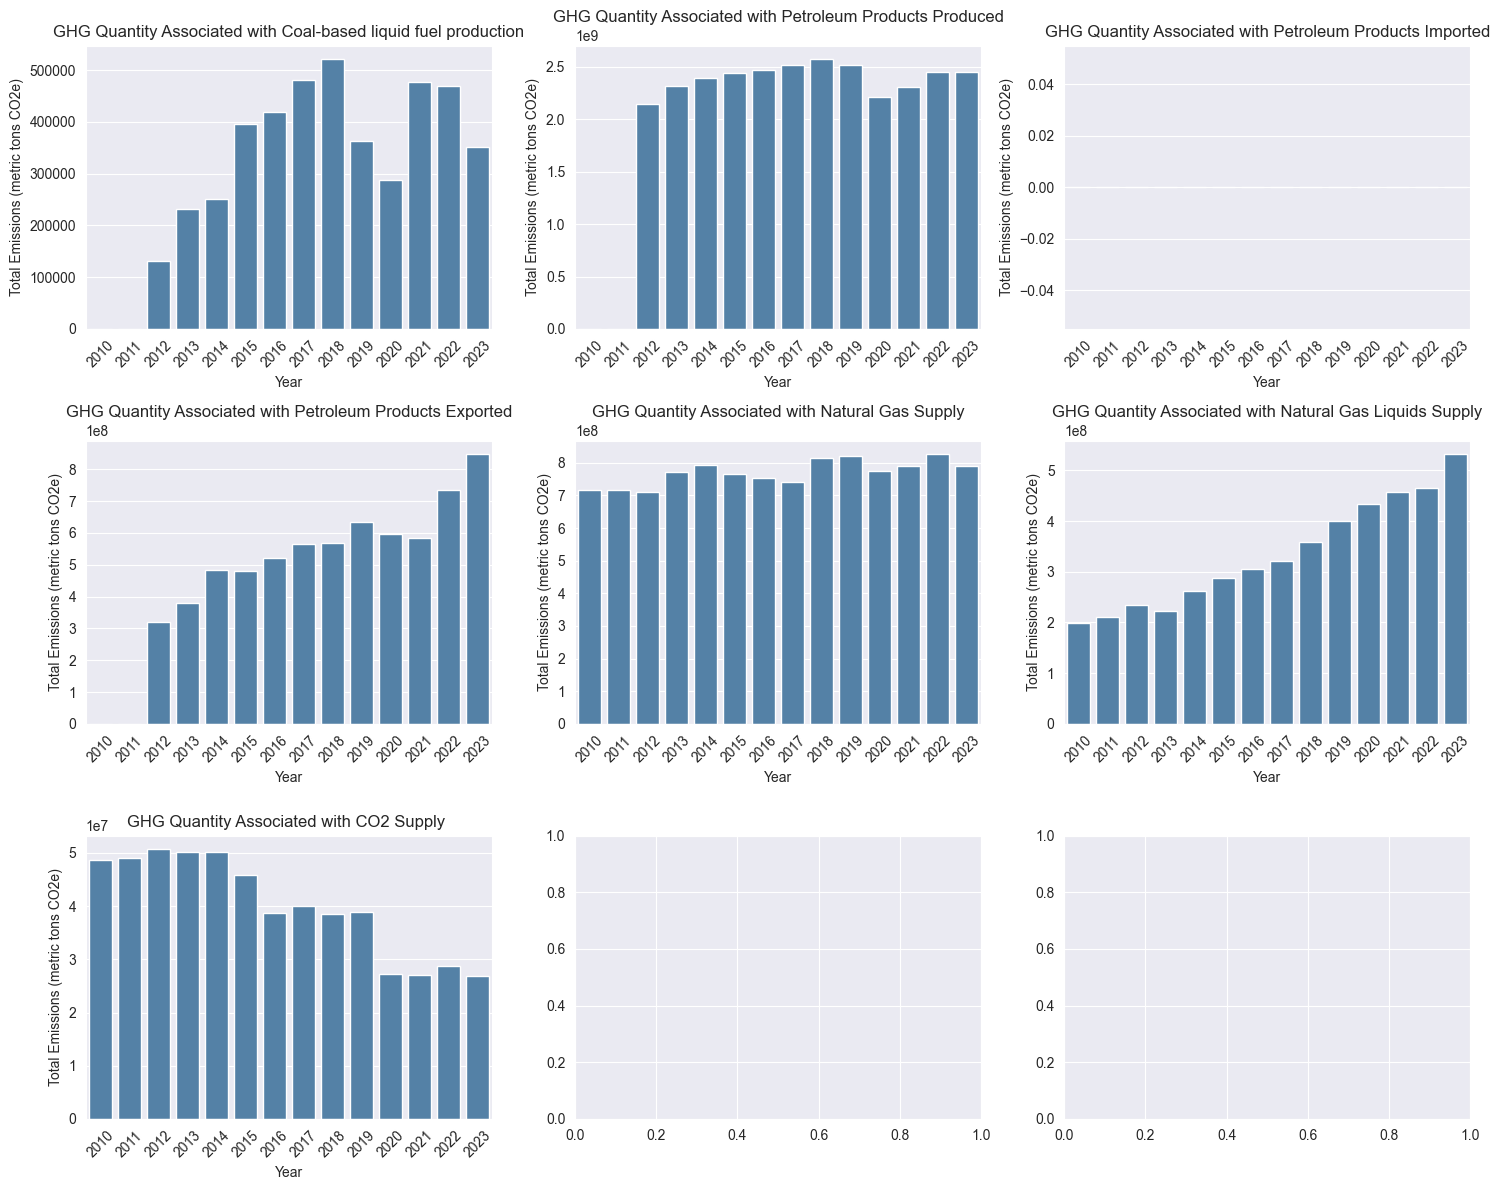

In [14]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=False)
axes = axes.flatten()

for i, col in enumerate(supplier_columns):
    sns.barplot(
        data=total_per_year_suppliers,
        x="Year",
        y=col,
        color="steelblue",
        ax=axes[i]
    )
    axes[i].set_title(col)
    axes[i].set_ylabel("Total Emissions (metric tons CO2e)")
    axes[i].set_xlabel("Year")
    axes[i].tick_params(axis="x", rotation=45)

# Hide any unused axes (since we have 7 categories but 9 axes in a 3x3 grid)
# for j in range(len(supplier_columns), len(axes)):
#     axes[j].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Similar code as above, but now combining direct and suppliers into "ALL".
# Load your saved data (if you already wrote it to CSV)
filepath = os.path.join(OUTPUT_DATA_DIR, "aggregated_emissions_by_facility.csv")
aggregated_all_years = pd.read_csv(filepath)

# Compute total direct emissions per year
total_per_year_all_emissions = (
    aggregated_all_years
    .groupby("Year")[supplier_columns + direct_columns + ["Total Direct Emissions", "Total Supplier Emissions", "Total Emissions"]]
    .sum(min_count=1)  # ignore all-NaN rows
    .reset_index()
    .fillna(0)
)


total_per_year_all_emissions.head()

filepath = os.path.join(OUTPUT_DATA_DIR, "aggregated_all_emissions_by_year.csv")
total_per_year_all_emissions.to_csv(filepath, index=False)
print("\nSaved to aggregated_all_emissions_by_year.csv")


Saved to aggregated_all_emissions_by_year.csv


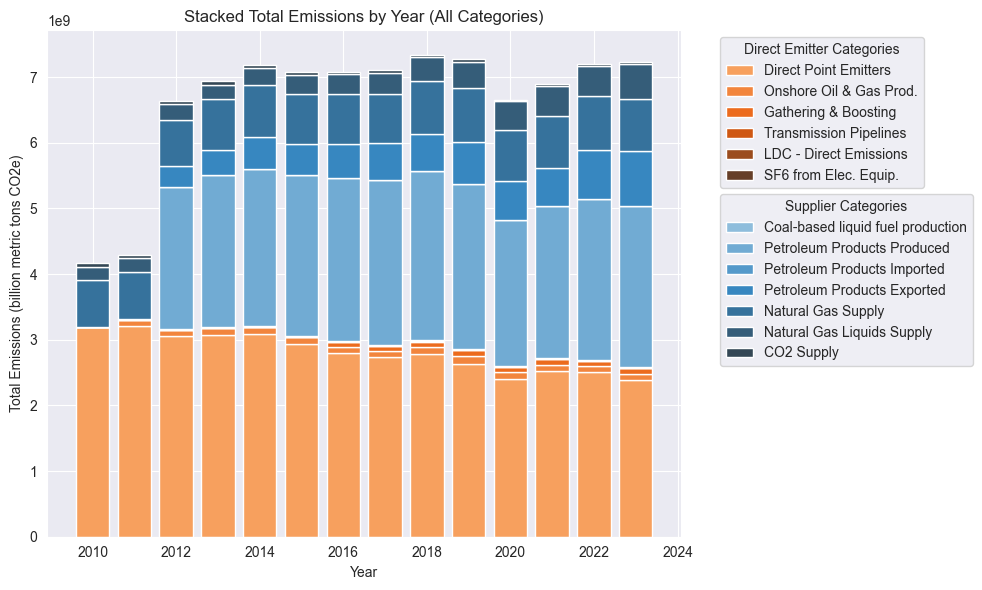

In [15]:
plt.figure(figsize=(10, 6))
sns.set_style("darkgrid")

filepath = os.path.join(OUTPUT_DATA_DIR, "aggregated_all_emissions_by_year.csv")
total_per_year_all_emissions = pd.read_csv(filepath)

bottom_vals = None
colors = sns.color_palette("Oranges_d", n_colors=len(direct_columns))
colors = colors + sns.color_palette("Blues_d", n_colors=len(supplier_columns))

def getLabel(name):
    if name in supplier_columns:
        return supplier_columns_short[supplier_columns.index(name)]
    else:
        return name

for i, col in enumerate(direct_columns + supplier_columns):
    plt.bar(
        total_per_year_all_emissions["Year"],
        total_per_year_all_emissions[col],
        bottom=bottom_vals,
        color=colors[i],
        label=getLabel(col)
    )
    bottom_vals = (
        total_per_year_all_emissions[col]
        if bottom_vals is None
        else bottom_vals + total_per_year_all_emissions[col]
    )

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()

direct_handles = []
direct_labels = []
supplier_handles = []
supplier_labels = []

for h, l in zip(handles, labels):
    if l in direct_columns:
        direct_handles.append(h)
        direct_labels.append(l)
    elif l in supplier_columns_short:
        supplier_handles.append(h)
        supplier_labels.append(l)

legend_direct = ax.legend(
    direct_handles,
    direct_labels,
    title="Direct Emitter Categories",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

legend_supplier = ax.legend(
    supplier_handles,
    supplier_labels,
    title="Supplier Categories",
    bbox_to_anchor=(1.05, 0.69),
    loc="upper left"
)

ax.add_artist(legend_direct)


plt.title("Stacked Total Emissions by Year (All Categories)")
plt.xlabel("Year")
plt.ylabel("Total Emissions (billion metric tons CO2e)")
#plt.legend(title="Emission Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [ ]:
# Load your saved data (if you already wrote it to CSV)
filepath = os.path.join(OUTPUT_DATA_DIR, "aggregated_emissions_by_facility.csv")
aggregated_all_years = pd.read_csv(filepath)

# Create lookup table for Address and other fields
file_2023 = os.path.join(DATA_DIR, "ghgp_data_by_year_2023.xlsx")
direct_2023 = pd.read_excel(file_2023, sheet_name="Direct Point Emitters", header=3)
supply_2023 = pd.read_excel(file_2023, sheet_name="Suppliers", header=3)

meta_cols = [
    "FRS Id", "Address", "City", "State", "Zip Code",
    "County", "Latitude", "Longitude", "Primary NAICS Code", "Latest Reported Industry Type (subparts)"
]

# Columns needed for merge
key_cols = ["Facility Id", "Facility Name"]

# Keep only key + metadata for each sheet
direct_lu = direct_2023[key_cols + meta_cols + ["Latest Reported Industry Type (sectors)"]].copy()
supply_lu = supply_2023[key_cols + meta_cols].copy()

# Set index to (Facility Id, Facility Name) pair
direct_lu_i = direct_lu.set_index(key_cols)
supply_lu_i = supply_lu.set_index(key_cols)

# Combine the direct/supplier lookup tables
lookup = direct_lu_i.combine_first(supply_lu_i).reset_index()
# Lookup table is done.

# these next lines verify that "lookup" has no entires with null/empty values for FRS Id
# FRS Id must be there, and an important entry, thus we check this and not necessarily other values.
# Output a list of these facilities with no FRSID to a file to inspect manually:
# facilities_with_no_FRSID = lookup[(lookup["FRS Id"].isna()) | (lookup["FRS Id"] == "")]
# print(facilities_with_no_FRSID)
# filepath = os.path.join(OUTPUT_DATA_DIR, "facilities_with_no_FRSID.csv")
# facilities_with_no_FRSID.to_csv(filepath, index=False)

aggregated_all_years = aggregated_all_years.merge(
    lookup,
    on=["Facility Id", "Facility Name"],
    how="left"
)

filepath = os.path.join(OUTPUT_DATA_DIR, "aggregated_emissions_by_facility_with_metadata.csv")
aggregated_all_years.to_csv(filepath)

TOP DIRECT EMITTERS BY FACILITY:

      Facility Id               Facility Name  Total Direct Emissions  \
7159      1007227           James H Miller Jr            2.770984e+08   
1043      1001051                     Scherer            2.231918e+08   
211       1000192                     Labadie            2.144483e+08   
699       1000676                      Monroe            2.099161e+08   
1182      1001194               Gen J M Gavin            2.019624e+08   
7411      1007504                 Martin Lake            2.019231e+08   
6800      1006868                  W A Parish            1.991424e+08   
1021      1001030                      Gibson            1.940176e+08   
1011      1001020                    Colstrip            1.852777e+08   
1494      1001505                       Bowen            1.760251e+08   
1180      1001192                 Jim Bridger            1.711769e+08   
7412      1007505                   Oak Grove            1.691235e+08   
960       1000967

In [5]:
filepath = os.path.join(OUTPUT_DATA_DIR, "aggregated_emissions_by_facility_with_metadata.csv")
aggregated_all_years = pd.read_csv(filepath)

# Build dictionary of metadata columns we want to keep.
non_metadata_cols = ["Total Direct Emissions", "Total Supplier Emissions", "Total Emissions"] + supplier_columns + direct_columns
metadata_cols = aggregated_all_years.columns.difference(non_metadata_cols)

aggregation_dict = {col: "first" for col in metadata_cols}
aggregation_dict.update({col: "sum" for col in non_metadata_cols})

top_emitters_facility = (
    aggregated_all_years
    .groupby("Facility Id", as_index=False)
    .agg(aggregation_dict)
)

filepath = os.path.join(OUTPUT_DATA_DIR, "top_emitters_by_facility_with_metadata.csv")
top_emitters_facility.to_csv(filepath)

top_direct_emitters_facility = top_emitters_facility.sort_values("Total Direct Emissions", ascending=False)
top_supplier_emitters_facility = top_emitters_facility.sort_values("Total Supplier Emissions", ascending=False)

print("TOP DIRECT EMITTERS BY FACILITY:\n")
print(top_direct_emitters_facility.head(25))
print("\n\nTOP SUPPLIER EMITTERS BY FACILITY:\n")
print(top_supplier_emitters_facility.head(25))

TOP DIRECT EMITTERS BY FACILITY:

                            Address             City               County  \
6357               4250 Porter Road          Quinton            Jefferson   
935                10986 HIGHWAY 87         JULIETTE               Monroe   
179    226 LABADIE POWER PLANT ROAD          LABADIE             Franklin   
609                   3500 FRONT ST           MONROE               Monroe   
1066                   OHIO ROUTE 7         CHESHIRE               Gallia   
6578             8850 FM 2658 North            Tatum                 Rusk   
6040                    YU JONES RD        THOMPSONS            Fort Bend   
914                    1097 N 950 W       OWENSVILLE               Gibson   
904                1 WAREHOUSE ROAD         COLSTRIP              Rosebud   
1358     317 COVERED BRIDGE ROAD SW     CARTERSVILLE               Bartow   
1064  35 MILES EAST OF ROCK SPRINGS   POINT OF ROCKS           Sweetwater   
6579            8127 Oak Grove Road       

In [ ]:
# Before any future processing related to counties or other geographical divisions of the US, we need
# to create a standard data set that queries the USGS geocoding service and gets information about every facility.

# This block creates the basefile which has a list of every facility, ID, and relevant metadata.
# Because the block below this ADDS to the resulting file (facility_metadata.csv), we don't want any
# accidental runs of this block again because that data will be overwritten. Because of this risk,
# the output path for this block has been set to "facility_metadata_2.csv".

filepath = os.path.join(OUTPUT_DATA_DIR, "aggregated_emissions_by_facility_with_metadata.csv")
aggregated_all_years = pd.read_csv(filepath)

# Core metadata columns we want to keep
facility_cols = [
    "Facility Id",
    "Facility Name",
    "Latitude",
    "Longitude",
    "Address",
    "State",
    "Zip Code",
    "Parent Company",
    "Parent Ownership %",
    "Latest Reported Industry Type (sectors)",
    "Latest Reported Industry Type (subparts)",
    "Primary NAICS Code",
]

# Keep only relevant columns
df_facilities = aggregated_all_years[facility_cols]

# Collapse long-form data in aggregated_all_years to one row per facility.
facility_usgeo_metadata = (
    df_facilities
    .sort_values("Facility Id")
    .groupby("Facility Id", as_index=False)
    .last()
)

# Save
outpath = os.path.join(
    OUTPUT_DATA_DIR,
    "facility_metadata_2.csv"
)
facility_usgeo_metadata.to_csv(outpath, index=False)


In [ ]:
# Provided the above block has been run and "facility_metadata.csv" is generated,
# this code block queries the US Census's Geocoding service to manually get the County and
# Congressional District for each facility based on the facility's given coordinates.

# This has been run once already, and results save to facility_metadata.csv.
# Processing every entry takes about an hour, so this doesn't need to be run again unless we
# really need to.

original_path = os.path.join(OUTPUT_DATA_DIR, "aggregated_emissions_by_facility_with_metadata.csv")
if not os.path.exists(original_path):
    print("aggregated_emissions_by_facility_with_metadata.csv doesn't exist.")
else:
    filepath = os.path.join(OUTPUT_DATA_DIR, "facility_metadata.csv")
    if not os.path.exists(filepath):
        print("facility_metadata.csv doesn't exist, please ensure the previous code block has been run.")
    else:
        progress = pd.read_csv(filepath)
        
        # We define all the properties we want to get from USGEO service.
        # This dictionary's keys will be the name we store each property as in the table.
        # The values will be a function that accesses the appropriate data in the given json object.
        properties_to_retrieve = {
            "County_from_API": lambda dat: dat['result']['geographies']['Counties'][0]['BASENAME'],
            "County_FIPS": lambda dat: dat['result']['geographies']['Counties'][0]['GEOID'],
            "2024_State_Legislative_Districts_Upper": lambda dat: dat['result']['geographies']['2024 State Legislative Districts - Upper'][0]['BASENAME'],
            "2024_State_Legislative_Districts_Lower": lambda dat: dat['result']['geographies']['2024 State Legislative Districts - Lower'][0]['BASENAME'],
            "Congressional_District": lambda dat: dat['result']['geographies']['119th Congressional Districts'][0]['BASENAME'],
        }
        
        # Generate the columns in "progress" if they doesn't exist.
        for key in properties_to_retrieve:
            if key not in progress.columns:
                progress[key] = pd.NA
        
        for i, series in progress.iterrows():
            cols = list(properties_to_retrieve.keys())
            if series[cols].isna().any():
                if pd.notna(series['Longitude']) and pd.notna(series['Latitude']):
                    url = f"https://geocoding.geo.census.gov/geocoder/geographies/coordinates?x={series['Longitude']}&y={series['Latitude']}&benchmark=4&vintage=Current_Current&format=json"
                    try:
                        with urlopen(url) as response:
                            dat = json.load(response)

                        updates = {}
                        error_in_updates = False
                        for col, extractor in properties_to_retrieve.items():
                            try:
                                updates[col] = extractor(dat)
                            except Exception as ex:
                                updates[col] = pd.NA
                                error_in_updates = True

                        if error_in_updates:
                            print(f"One or more errors in extracting data for updating facility {series['Facility Id']}. Update object: {updates}")
                        # update the data
                        progress.loc[i, updates.keys()] = list(updates.values())
                        print(
                            f"Finished USGEO lookup {i}: "
                            f"({series['Longitude']}, {series['Latitude']})"
                        )

                    except Exception as e:
                        print(f"Error on row {i}: {e}")
                        progress.to_csv(filepath, index=False)
                else:
                    print(f"No lat/lon data for facility {series['Facility Id']}: {series['Facility Name']}")
            else:
                print(f"Entry already exists for ({series['Longitude']},{series['Latitude']}) = {series['County_from_API']}. Original County: {series['County']}")

        progress.to_csv(filepath)

Finished USGEO lookup 0: (-122.685533, 48.828707)
Finished USGEO lookup 1: (-85.198134, 40.371053)
Finished USGEO lookup 2: (-78.391883, 36.291066)
Finished USGEO lookup 3: (-89.353796, 40.157643)
Finished USGEO lookup 4: (-120.10151, 36.92375)
Finished USGEO lookup 5: (-71.510556, 42.127778)
Finished USGEO lookup 6: (-106.5275, 35.330083)
Finished USGEO lookup 7: (-74.8756, 44.9293)
Finished USGEO lookup 8: (-87.0621, 30.5804)
Finished USGEO lookup 9: (-73.931605, 41.690648)
Finished USGEO lookup 10: (-81.163333, 36.143889)
Finished USGEO lookup 11: (-80.72108, 35.95458)
Finished USGEO lookup 12: (-91.436791, 39.834118)
One or more errors in extracting data for updating facility 1000019. Update object: {'County_from_API': 'Scotts Bluff', 'County_FIPS': '31157', '2024_State_Legislative_Districts_Upper': '48', '2024_State_Legislative_Districts_Lower': <NA>, 'Congressional_District': '3'}
Finished USGEO lookup 13: (-103.633, 41.85942)
Finished USGEO lookup 14: (-78.28699, 41.81787)
Finis

In [21]:
# Helper function that picks the first "non null" entry for some data column.
# Used for anything that we don't wanna sum, but rather keep valid entries.
def first_non_null(series):
    valid = series.dropna()
    return valid.iloc[0] if len(valid) else np.nan

filepath = os.path.join(OUTPUT_DATA_DIR, "aggregated_emissions_by_facility_with_metadata.csv")
aggregated_all_years = pd.read_csv(filepath)

# Columns to sum
cols_to_sum = [
    "Total Emissions",
    "Total Direct Emissions",
    "Total Supplier Emissions"
] + direct_columns + supplier_columns

# Build dictionary which pandas will use to sum the appropriate columns
aggregation_dictionary = {}
for col in cols_to_sum:
    if col in aggregated_all_years.columns:
        aggregation_dictionary[col] = "sum"

state_grouped = aggregated_all_years.groupby(["State", "Year"]).agg(aggregation_dictionary)

print(state_grouped.head(25))
filepath = os.path.join(OUTPUT_DATA_DIR, "aggregated_emissions_by_state.csv")
state_grouped.to_csv(filepath)
# The following lines are important, as they save it to the json format which will be used
# externally for showing this data on a javascript application
filepath = os.path.join(OUTPUT_DATA_DIR, "aggregated_emissions_by_state.json")
state_grouped.reset_index().to_json(filepath, orient="records")

            Total Emissions  Total Direct Emissions  Total Supplier Emissions  \
State Year                                                                      
AK    2010     1.128728e+07            1.128728e+07              0.000000e+00   
      2011     1.194871e+07            1.194871e+07              0.000000e+00   
      2012     2.601983e+07            1.246488e+07              1.355495e+07   
      2013     2.667073e+07            1.205207e+07              1.461866e+07   
      2014     3.133079e+07            1.815887e+07              1.317192e+07   
      2015     3.119096e+07            1.849620e+07              1.269476e+07   
      2016     2.670149e+07            1.496579e+07              1.173570e+07   
      2017     2.973265e+07            1.519513e+07              1.453752e+07   
      2018     2.818813e+07            1.423083e+07              1.395730e+07   
      2019     2.788514e+07            1.432415e+07              1.356100e+07   
      2020     2.640962e+07 

In [23]:
# Graph view of state-level emissions data
sns.set_style("dark")

filepath = os.path.join(OUTPUT_DATA_DIR, "aggregated_emissions_by_state.csv")
state_grouped = pd.read_csv(filepath)

def plot_state_emissions_grouped(years, emissions_category="Total Emissions"):
    """
    Plot grouped bar chart of state emissions for multiple years.
    States are ordered by emissions amount in the last year given, descending.
    """

    # Ensure years are sorted
    years = sorted(years)

    # Slice all requested years
    df_slice = (
        state_grouped
        .loc[(slice(None), years), emissions_category]
        .unstack("Year")
    )

    # Sort states by the last year's emissions, take only the top 15
    df_slice = df_slice.sort_values(years[-1], ascending=False).head(15)

    # Plot
    ax = df_slice.plot(
        kind="bar",
        figsize=(15, 8),
        width=0.8
    )

    ax.set_title(f"{emissions_category} by State ({', '.join(map(str, years))})")
    ax.set_xlabel("State")
    ax.set_ylabel(f"{emissions_category} (CO₂e)")
    ax.legend(title="Year")
    ax.tick_params(axis="x", rotation=90)

    plt.tight_layout()
    plt.show()

plot_state_emissions_grouped([2012, 2018, 2023], emissions_category="Total Supplier Emissions")
plot_state_emissions_grouped([2012, 2018, 2023], emissions_category="Total Direct Emissions")

AssertionError: 

In [ ]:
filepath = os.path.join(OUTPUT_DATA_DIR, "aggregated_emissions_by_state.csv")
state_grouped = pd.read_csv(filepath)

year = 2010
emissions_category = "Total Direct Emissions"

fig = plotly.express.choropleth(
    state_grouped,
    locations="State",
    locationmode="USA-states",
    color=emissions_category,
    scope="usa",
    color_continuous_scale="OrRd",
    labels={emissions_category: f"tons CO₂e"},
    animation_frame='Year',
    width=700,
    height=500,
)

fig.show()

In [24]:
# Get county data 
url_codes = os.path.join(DATA_DIR, "national_county2020.txt")
codes = pd.read_csv(
    url_codes,
    dtype=str,
    sep="|",
    header=0,
    names=[
        "STATE",
        "STATEFP",
        "COUNTYFP",
        "COUNTYNS",
        "COUNTYNAME",
        "CLASSFP",
        "FUNCSTAT"
    ]
)

codes["County_FIPS"] = codes["STATEFP"] + codes["COUNTYFP"]

## The following lines are to see what the suffixes for the county names in 'codes' looks like.
## Not necessary for the rest of the block to run.
# codes["county_suffix_1"] = codes["COUNTYNAME"].str.strip().str.split().str[-1]
# suffix_counts_1 = (
#     codes["county_suffix_1"]
#     .value_counts()
#     .sort_values(ascending=False)
# )
# print(suffix_counts_1)

# The above code was used to get a list of suffixes we need to filter from our list of county names:
SUFFIXES = [
    "City and Borough",
    "Census Area",
    "County",
    "Municipio",
    "Parish",
    "Borough",
    "Area",
    "Municipality",
    "Islands",
    "Island",
    "City",
]

## Now, use the suffixes to form a regex and normalize the county names:
suffix_pattern = re.compile(
    r"\s+\b(" + "|".join(SUFFIXES) + r")\b\s*$",
    flags=re.IGNORECASE
)
codes["COUNTYNAME_cleaned"] = (codes["COUNTYNAME"].astype(str)
    .str.strip()
    .str.replace(suffix_pattern, "", regex=True)
)

filepath = os.path.join(OUTPUT_DATA_DIR, "aggregated_emissions_by_facility_with_metadata_counties.csv")
aggregated_all_years_with_counties = pd.read_csv(filepath)

# Create a full county/year grid
all_years = aggregated_all_years_with_counties["Year"].unique()
full_index = pd.MultiIndex.from_product(
    [codes["County_FIPS"], all_years],
    names=["County_FIPS", "Year"]
)

# Columns to sum
cols_to_sum = [
    "Total Emissions",
    "Total Direct Emissions",
    "Total Supplier Emissions"
] + direct_columns + supplier_columns

# Build dictionary which pandas will use to sum the appropriate columns
aggregation_dictionary = {}
for col in cols_to_sum:
    if col in aggregated_all_years_with_counties.columns:
        aggregation_dictionary[col] = "sum"

county_grouped = aggregated_all_years_with_counties.merge(
    codes[["STATE", "COUNTYNAME_cleaned", "County_FIPS"]],
    left_on=["State", "County_from_API"],
    right_on=["STATE", "COUNTYNAME_cleaned"],
    how="left"
)

county_grouped = (county_grouped
    .groupby(["County_FIPS", "Year"], as_index=False)
    .agg(aggregation_dictionary)
    .reset_index()
)

# Create a full multi-index of all year/county combinations. We need to do this because
# the original facility data won't have EVERY county in it, since many counties don't have
# any facilities at all. To make sure the map shows ALL counties, we create this multindex,
# then use it later when displaying the county-level map.
years = county_grouped["Year"].unique()
full_index = pd.MultiIndex.from_product(
    [codes["County_FIPS"].unique(), years],
    names=["County_FIPS", "Year"]
)

county_grouped = (
    county_grouped
    .set_index(["County_FIPS", "Year"])
    .reindex(full_index)
    .fillna(0)
    .reset_index()
)

county_grouped = county_grouped.merge(
    codes[["County_FIPS", "STATE", "COUNTYNAME_cleaned"]],
    on="County_FIPS",
    how="left",
)

# Last step is to reorder the columns so we can use them in the next mapping step:
# Desired columns in front (only keep those that exist)
front_cols = [
    "State",
    "COUNTYNAME_cleaned",
    "County_FIPS",
    "Year"
]
front_cols = [c for c in front_cols if c in county_grouped.columns]
other_cols = [c for c in county_grouped.columns if c not in front_cols]
county_grouped = county_grouped[front_cols + other_cols]

print(county_grouped.head(15))

filepath = os.path.join(OUTPUT_DATA_DIR, "aggregated_emissions_by_county.csv")
county_grouped.to_csv(filepath)
# The following lines are important, as they save it to the json format which will be used
# externally for showing this data on a javascript application
filepath = os.path.join(OUTPUT_DATA_DIR, "aggregated_emissions_by_county.json")
county_grouped.reset_index().to_json(filepath, orient="records")

   COUNTYNAME_cleaned County_FIPS  Year  index  Total Emissions  \
0             Autauga       01001  2010    0.0      2296803.674   
1             Autauga       01001  2011    1.0      3210154.758   
2             Autauga       01001  2012    2.0      3936534.496   
3             Autauga       01001  2013    3.0      3365861.890   
4             Autauga       01001  2014    4.0      5388098.432   
5             Autauga       01001  2015    5.0      6531961.946   
6             Autauga       01001  2016    6.0      5999899.896   
7             Autauga       01001  2017    7.0      4796002.468   
8             Autauga       01001  2018    8.0      5084529.918   
9             Autauga       01001  2019    9.0      4809894.832   
10            Autauga       01001  2020   10.0      5008617.182   
11            Autauga       01001  2021   11.0      4707873.446   
12            Autauga       01001  2022   12.0      6078344.734   
13            Autauga       01001  2023   13.0      5813957.18

In [ ]:
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

filepath = os.path.join(OUTPUT_DATA_DIR, "aggregated_emissions_by_county.csv")
county_grouped = pd.read_csv(filepath, dtype={"County_FIPS": str})

emissions_category = "Total Direct Emissions"

fig = plotly.express.choropleth(
    county_grouped,
    geojson=counties,
    locations="County_FIPS",
    featureidkey="id",
    color=emissions_category,
    animation_frame="Year",
    scope="usa",
    color_continuous_scale="OrRd",
    labels={emissions_category: "tons CO₂e"},
    hover_data=["STATE", "COUNTYNAME_cleaned"],
    width=900,
    height=700
)

fig.update_layout(
    title_text=f"{emissions_category} by County",
    title_x=0.5,
    geo=dict(
        showland=True,
        landcolor="white",
        showlakes=False,
        showframe=False,
        showcoastlines=False
    ),
    #margin=dict(l=20, r=20, t=60, b=20)
)

fig.show()

In [ ]:
import plotly.graph_objects as go

# This block will calculate the rate of change of each metric for each state.
# We simply look at the emissions amount in 2023, subtract from 2012 amount, then divide by number of years (so, 12)
filepath = os.path.join(OUTPUT_DATA_DIR, "aggregated_emissions_by_state.csv")
state_grouped = pd.read_csv(filepath)

# Metrics
metrics = [
    "Total Emissions",
    "Total Direct Emissions",
    "Total Supplier Emissions"
] + direct_columns + supplier_columns

df = state_grouped.reset_index()

# Filter to the years we want, if necessary. Since 2010 and 2011 contain some incomplete data, we exclude them.
df = df[df["Year"] > 2011]

rate_tables = {}

for metric in metrics:
    if metric not in df.columns:
        continue

    tmp = df[["State", "Year", metric]].dropna(subset=[metric])

    roc = (
        tmp.sort_values("Year")
           .groupby("State")
           .apply(lambda g: (g[metric].iloc[-1] - g[metric].iloc[0]) /
                            (g["Year"].iloc[-1] - g["Year"].iloc[0]))
           .reset_index(name="avg_annual_change")
    )

    rate_tables[metric] = roc

fig = go.Figure()

metric_names = list(rate_tables.keys())

for i, metric in enumerate(metric_names):
    roc = rate_tables[metric]

    fig.add_trace(
        go.Choropleth(
            locations=roc["State"],
            locationmode="USA-states",
            z=roc["avg_annual_change"],
            colorscale="RdBu_r",
            zmid=0,
            visible=(i == 0),
            colorbar_title="Avg annual change (tons CO2e)"
        )
    )

fig.update_layout(
    geo_scope="usa",
    margin=dict(l=20, r=20, t=100, b=20),
    title=dict(
        text=f"Average Annual Change (2012 - 2023): {metric_names[0]}",
        x=0.5,
        y=0.92
    ),
    updatemenus=[{
        "type": "dropdown",
        "direction": "down",
        "x": 0.5,
        "xanchor": "center",
        "y": 1.08,
        "yanchor": "top",
        "buttons": [
            {
                "label": metric,
                "method": "update",
                "args": [
                    {"visible": [j == i for j in range(len(metric_names))]},
                    {"title.text": f"Average Annual Change (2012 - 2023): {metric}"}
                ]
            }
            for i, metric in enumerate(metric_names)
        ]
    }]
)


fig.show()


In [27]:
# Create waffle and pie charts, adapted from Carly Hagen's code. This block won't produce output, it just builds the functions necessary
# to create the waffle and pie charts.

# First import our data file.
filepath = os.path.join(OUTPUT_DATA_DIR, "aggregated_emissions_by_facility_with_metadata.csv")
aggregated_all_years = pd.read_csv(filepath)

# Create waffle chart function:
def create_wafflechart(title, data, colormap):
    values = list(data.values())
    labels = list(data.keys())

    norm = matplotlib.colors.Normalize(vmin=0, vmax=len(values))
    colors = [colormap(norm(i)) for i in range(len(values))]

    plt.figure(
        FigureClass=Waffle,
        rows=30,
        columns=30,
        values=values,
        labels=labels,
        legend={
            'loc': 'upper left',
            'bbox_to_anchor': (1.05, 1),
            'frameon': False,
            'fontsize': 9,
            'labelcolor': 'black'
        },
        colors=colors,
        facecolor='white'
    )

    plt.title(title, fontsize=15, color="black")
    plt.show()

# Create pie chart function
# top_counts is a list of different separations of "top X suppliers/direct emitters."
# E.g. if you give top_counts = [10, 50], it will generate two pies side by side, one showing top 10 vs others and one showing top 50 vs others.
def top_pie(data, value_col, top_counts, title, noun, angle, top_color, bottom_color):
    fig, axes = plt.subplots(
        1, len(top_counts),
        figsize=(6 * len(top_counts), 5),
        facecolor="white"
    )

    if len(top_counts) == 1:
        axes = [axes]  # make iterable if there's only one pie to make
    
    for ax, top_count in zip(axes, top_counts):
        count = len(data)
        bottom_count = count - top_count

        top_emitters = data.nlargest(top_count, value_col)
        bottom_emitters = data.nsmallest(bottom_count, value_col)

        top_sum = top_emitters[value_col].sum()
        bottom_sum = bottom_emitters[value_col].sum()
        total = top_sum + bottom_sum

        top_pct = 100 * top_sum / total
        bottom_pct = 100 * bottom_sum / total

        labels = [
            f"Top {top_count}\n{noun} ({top_pct:.1f}%)",
            f"Bottom {bottom_count}\n{noun} ({bottom_pct:.1f}%)"
        ]

        ax.pie(
            [top_sum, bottom_sum],
            labels=labels,
            startangle=angle,
            counterclock=False,
            labeldistance=1.15,
            colors=[top_color, bottom_color],
            textprops={'color': 'black', 'fontsize': 9}
        )
        ax.set_title(f"Top {top_count} {noun}", fontsize=12, color="black")
    
    fig.suptitle(title, fontsize=15)
    plt.tight_layout()
    plt.show()


# Given a year, create a summary of ownership for that year
def parent_summary_for_year(year, emissions_col, top_n=20):
    df = aggregated_all_years[
        (aggregated_all_years["Year"] == year) &
        (aggregated_all_years["Parent Company"].notna())
    ]

    summary = (
        df.groupby("Parent Company")[emissions_col]
        .sum()
        .sort_values(ascending=False)
    )

    return summary, summary.head(top_n)

# Finally, the function that displays charts given a year as input:
def plot_parent_company_charts(year, num_companies, num_companies_2=50):
    emissions_col = "Total Direct Emissions"
    suppliers_col = "Total Supplier Emissions"

    # Direct emitters:
    all_direct, top_direct = parent_summary_for_year(year, emissions_col, top_n=num_companies)

    create_wafflechart(
        f"Direct Emissions by Top {num_companies} Parent Companies: {year}",
        top_direct.to_dict(),
        matplotlib.cm.Spectral
    )

    top_pie(
        all_direct.reset_index(name="value"),
        "value",
        [num_companies, num_companies_2],
        f"Direct Emissions by Parent Company: {year}",
        "Emitters",
        90,
        "#f98e52",
        "#3387bc"
    )

    # Suppliers:
    all_sup, top_sup = parent_summary_for_year(year, suppliers_col, top_n=num_companies)

    create_wafflechart(
        f"Supplier Emissions by Top {num_companies} Parent Companies: {year}",
        top_sup.to_dict(),
        matplotlib.cm.Spectral
    )

    top_pie(
        all_sup.reset_index(name="value"),
        "value",
        [num_companies, num_companies_2],
        f"Supplier Emissions by Parent Company: {year}",
        "Suppliers",
        90,
        "#f98e52",
        "#3387bc"
    )

In [30]:
# Get the years we want available as options on the slider, then use ipywidgets.interact to plot:
years = sorted(aggregated_all_years["Year"].unique())

interact(
    plot_parent_company_charts,
    year=IntSlider(min=min(years), max=max(years), step=1, value=years[0]),
    num_companies=10
)

interactive(children=(IntSlider(value=2010, description='year', max=2023, min=2010), IntSlider(value=10, descr…

<function __main__.plot_parent_company_charts(year, num_companies, num_companies_2=50)>